In [1]:
import numpy as np
import urllib
import cv2
import os
import pickle
import random
import scipy
from scipy.misc import imread
import matplotlib.pyplot as plt
%matplotlib inline
import os


In [2]:
base_globalpath='/visual/Semi_test/'
base_queryFolderPath ='/visual/query_images/'

In [3]:
# get only jpg files (to remove .ds store)
def get_valid_image_files(image_path): 
    files = []
    for path in image_path:
        temp = []
        for p in sorted(os.listdir(path)):
            if p.endswith(".jpg"): 
                temp.append(path+"/"+p) 
        files.append(temp)
    return files

In [4]:
# get only jpg files (to remove .ds store)
def get_valid_query_files(image_path):
    queryfiles = []
    for p in sorted(os.listdir(image_path)):
            if p.endswith(".jpg"): 
                queryfiles.append(image_path+"/"+p)
    return queryfiles
    

In [5]:
def extract_features(image_path, vector_size=32):
   
    image = imread(image_path, mode="RGB")
    try:
#     Using KAZE
#         alg = cv2.KAZE_create()
#     Using SIFT
        alg = cv2.xfeatures2d.SIFT_create()
#     Using SURF
#         alg = cv2.xfeatures2d.SURF_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print('Error: ', e)
        return None

    return dsc


In [6]:
# For the same 3 category run this only once 
#  Extracts the files 
def batch_extractor(files, pickled_db_path=base_globalpath+'features.pck'):
    result = {}
    for f in files: 
        for image in f:
#         print('Extracting features from image %s' % f)
            imageName = image.split('/')[-1].lower()
            categoryName = image.split('/')[-2].lower()
#         To avoid key collision in the dictionary for the same image names
            key = imageName+':'+categoryName
            result[key] = extract_features(image)
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [7]:
class Matcher(object):

    def __init__(self, pickled_db_path=base_globalpath+'features.pck'):
        with open(pickled_db_path,"rb") as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)
    
    def match(self, image_path, topn):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()
        return nearest_img_paths, img_distances[nearest_ids].tolist()

In [8]:
def show_img(path):
    img =imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()

In [9]:
def run():
   
    images_path = []
    categoryList = ['Jeans' ,'Men_Coats','Lace_Dress']
    for category in categoryList:
            images_path.append(base_globalpath+category)

    files = get_valid_image_files(images_path)
    batch_extractor(files)
    queryfiles = get_valid_query_files(base_queryFolderPath)
    
    ma = Matcher(base_globalpath+'features.pck')
    
    for file in queryfiles:
#       Display top n images
        topn=3
        print('Query image ==========================================')
        show_img(file)
        names, match = ma.match(file, topn)
        print('Result images ========================================')
        for i in range(topn):
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value  
            print('Match %s' % (1-match[i]) )
            img = (names[i].split(':')[0])
            category = names[i].split(':')[-1].lower()
            if img.endswith(".jpg"): 
                        show_img(base_globalpath+category+'/'+img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Query image ==========================================


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


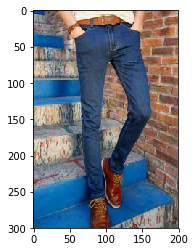

Result images ========================================
Match 0.5272625440886993


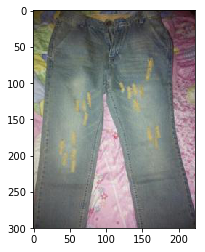

Match 0.5201633283643958


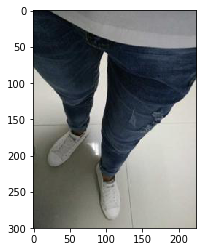

Match 0.5175010078895244


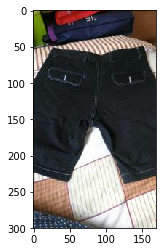

Query image ==========================================


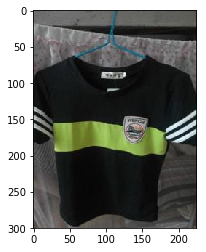

Result images ========================================
Match 0.5437197564627942


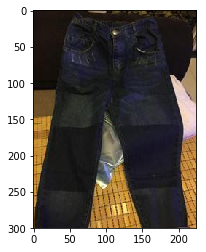

Match 0.5397524096327307


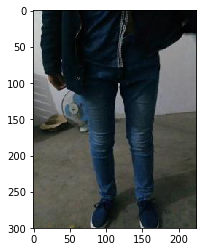

Match 0.5349267791433311


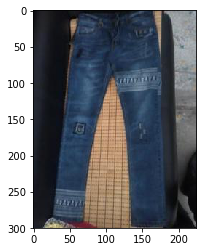

Query image ==========================================


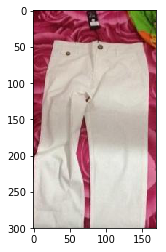

Result images ========================================
Match 0.5523667806617971


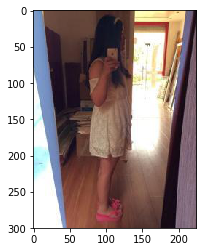

Match 0.5338395833997122


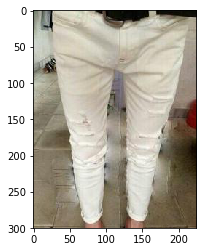

Match 0.5211301980611095


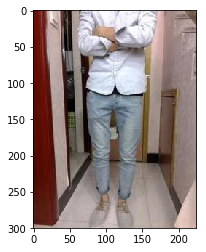

Query image ==========================================


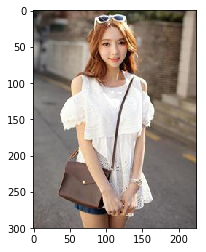

Result images ========================================
Match 0.5299244722468379


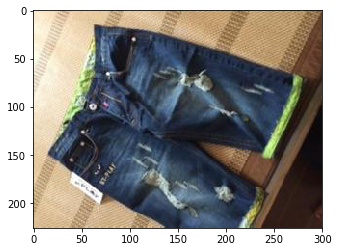

Match 0.5058126331796163


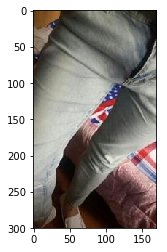

Match 0.503982192537442


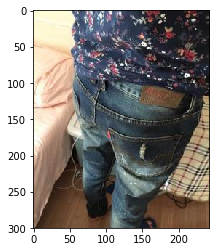

In [10]:
run()